In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F

from tqdm.notebook import tqdm # progress bar


In [2]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST("~/.pytorch/MNIST_data/", download=True, train=True, transform=transform)
testset = datasets.MNIST("~/.pytorch/MNIST_data/", download=True, train=False, transform=transform)


Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


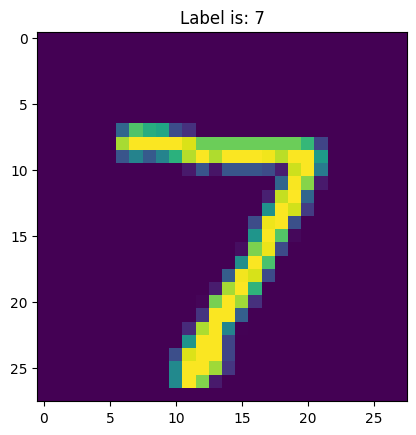

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(trainset, batch_size=batch_size)
test_dataloader = DataLoader(testset, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    
    # plt.imshow(X[0].reshape(28,28))
    plt.imshow(X[0][0])
    
    plt.title(f"Label is: {y[0]}")
    plt.show()
    
    break



In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")



Using cpu device


## Model

In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim) # mean of the latent Gaussian distribution
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim) # log-variance of the latent Gaussian distribution

        # Decoder layers
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [6]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [16]:
# Data

model = VAE(latent_dim=2)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# For logging
log_data = {
    'epoch_inputs': [],
    'epoch_outputs': [],
    'epoch_latents': [],
    'epoch_labels': [],
}

num_epoch = 50
# Training
for epoch in range(num_epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx == 0:
            # Store first batch of input, output, mu, labels
            n = min(data.size(0), 8)
            log_data['epoch_inputs'].append(data[:n].detach().cpu())
            log_data['epoch_outputs'].append(recon_batch[:n].detach().cpu())
            log_data['epoch_latents'].append(mu.detach().cpu())
            log_data['epoch_labels'].append(labels.detach().cpu())
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss / len(train_dataloader.dataset):.4f}')


Epoch 0, Loss: 181.9444
Epoch 5, Loss: 159.2556
Epoch 10, Loss: 155.6923
Epoch 15, Loss: 153.3910
Epoch 20, Loss: 151.6968
Epoch 25, Loss: 150.4658
Epoch 30, Loss: 149.5284
Epoch 35, Loss: 148.7725
Epoch 40, Loss: 148.1393
Epoch 45, Loss: 147.5814


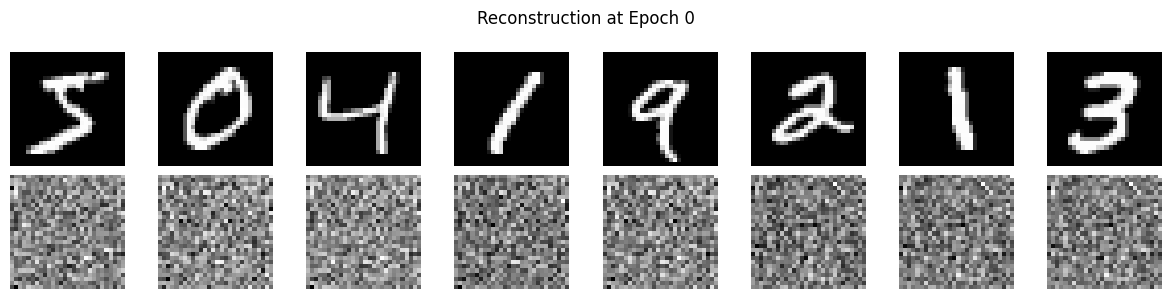

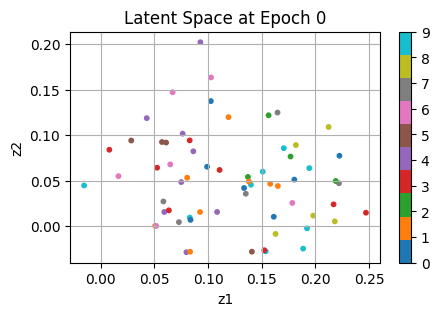

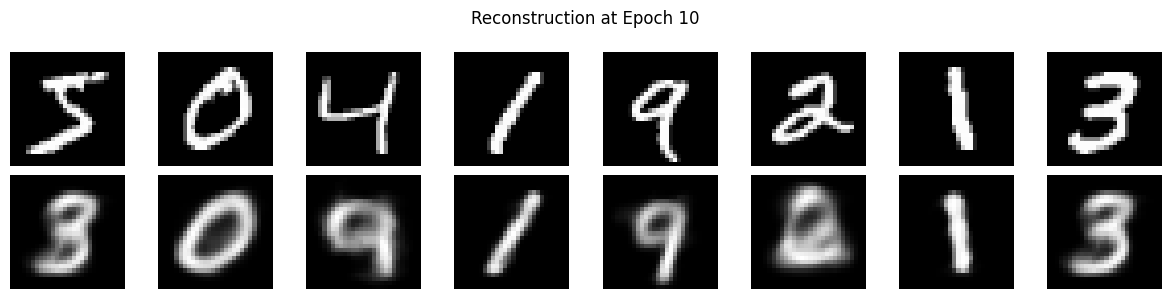

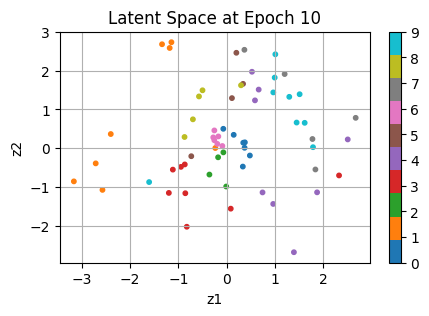

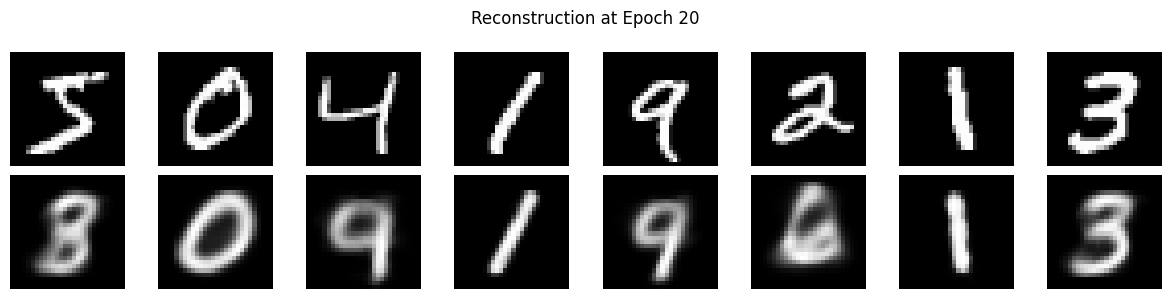

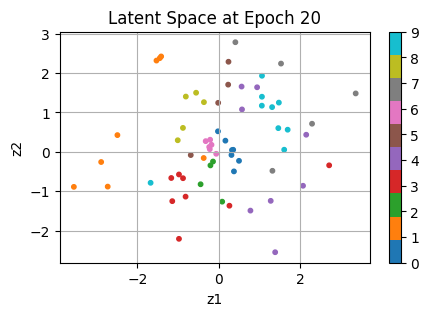

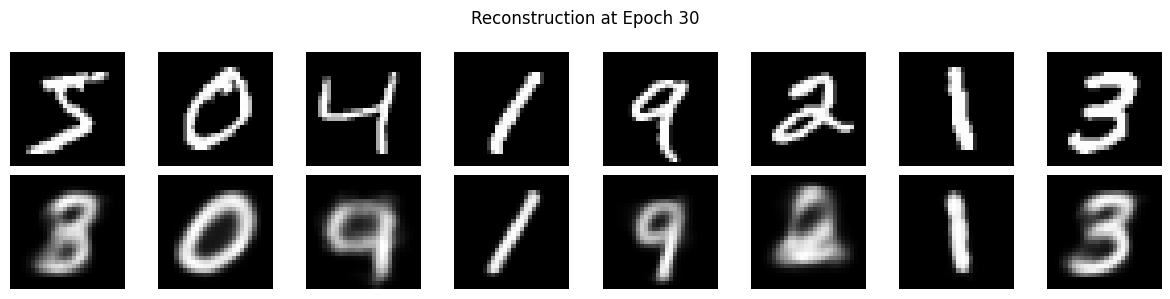

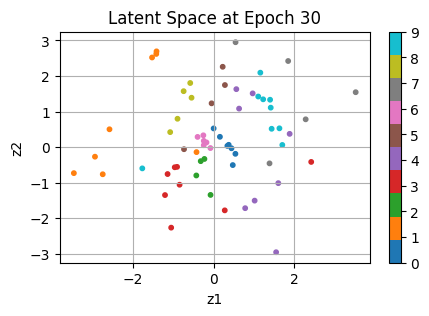

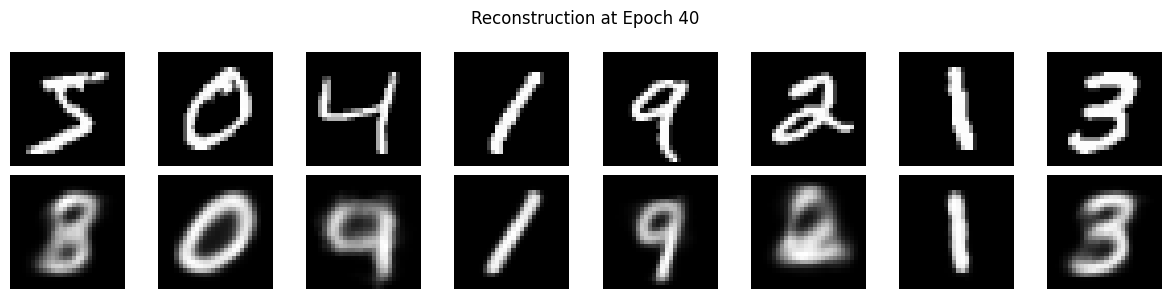

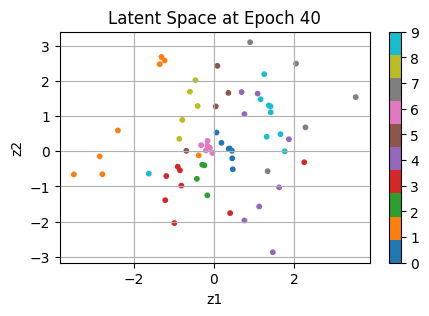

In [17]:
def plot_epoch(epoch):
    inputs = log_data['epoch_inputs'][epoch]
    outputs = log_data['epoch_outputs'][epoch]
    latents = log_data['epoch_latents'][epoch]
    labels = log_data['epoch_labels'][epoch]

    n = inputs.shape[0]
    
    # Plot reconstructions
    fig, axes = plt.subplots(2, n, figsize=(n * 1.5, 3))
    for i in range(n):
        axes[0, i].imshow(inputs[i].squeeze().numpy(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(outputs[i].view(28, 28).squeeze().numpy(), cmap='gray')
        axes[1, i].axis('off')
    axes[0, 0].set_ylabel('Input', fontsize=12)
    axes[1, 0].set_ylabel('Output', fontsize=12)
    plt.suptitle(f'Reconstruction at Epoch {epoch}')
    plt.tight_layout()
    plt.show()


    # Plot latent space
    if latents.shape[1] == 2:
        plt.figure(figsize=(5, 3))
        scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', s=10)
        plt.colorbar(scatter, ticks=range(10))
        plt.title(f'Latent Space at Epoch {epoch}')
        plt.xlabel('z1')
        plt.ylabel('z2')
        plt.grid(True)
        plt.show()

    # Plot 3D latent space
    elif latents.shape[1] == 3:
        fig = plt.figure(figsize=(6, 5))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(latents[:, 0], latents[:, 1], latents[:, 2], 
                             c=labels, cmap='tab10', s=10)
        legend = plt.colorbar(scatter, ticks=range(10))
        legend.set_label('Class label')
        ax.set_title(f'3D Latent Space at Epoch {epoch}')
        ax.set_xlabel('z1')
        ax.set_ylabel('z2')
        ax.set_zlabel('z3')
        plt.tight_layout()
        plt.show()


for epoch in range(0, num_epoch, 10):
    plot_epoch(epoch)